<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/T5_ftransfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip3 install wandb -q
!pip3 install dill -q

In [2]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip

import wandb

#!pip install transformers -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [29]:
pwd

'/home/jupyter/Projects'

In [3]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH

#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP

from optimizers import AdaFactor

In [ ]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Wed Jul 15 14:31:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [6]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

In [ ]:
##!pip install --upgrade wandb

In [ ]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [1]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [6]:
path = '/home/jupyter/' # GCp
#path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name) as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'valid')
#testset = read_data(path, 'test')

In [7]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [8]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [9]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [10]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [11]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64,
 text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [12]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [13]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length
      max_len, dataframe = self.get_max_tokens(dataframe)    

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, length in tqdm(enumerate(dataframe['article_len'])):
        #pragraph = len(paragraph.split())
        if length < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    #max_len, _ = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [14]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [15]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...



Done!


In [16]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...



Done!


In [17]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [18]:
doc_lengths

{'max_article_tokens': 115752,
 'min_article_tokens': 0,
 'max_summary_tokens': 6534,
 'min_summary_tokens': 0}

In [19]:
indices = np.where(train_processed['summary_len'] < 10)
#train_processed.iloc[indices[0]]

In [20]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [21]:
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)

In [22]:
train_processed_data.to_pickle("./preprocessed_train.pkl")

In [8]:
train_processed_data = pd.read_pickle("./preprocessed_train.pkl")

In [6]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [7]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [8]:
train_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [27]:
#valid_doc_lengths

{'max_article_tokens': 67366,
 'min_article_tokens': 5,
 'max_summary_tokens': 1502,
 'min_summary_tokens': 0}

In [28]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [29]:
valid_processed_data.to_pickle("./preprocessed_valid.pkl")

In [10]:
valid_processed_data = pd.read_pickle("./preprocessed_valid.pkl")

In [11]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [12]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [13]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [12]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [13]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [15]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + str(self.dataframe.text[idx]) + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + str(self.dataframe.summary[idx]) + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


#### Training Loop

In [17]:
def training(model, dataset_loader, optimizer, iteration=0):

  model.train()
  avg_loss = 0
  nItem = 0


  print(f'Start training for epoch: {iteration}')
 
  for idx, data_train in enumerate(dataset_loader):

    input_ids, source_mask, summary_ids, summary_mask = data_train

    input_ids = input_ids.to(device, dtype = torch.long)
    source_mask = source_mask.to(device, dtype = torch.float)
    summary_ids = summary_ids.to(device, dtype = torch.long)

    target_labels = summary_ids[:, :-1].contiguous()
    langm_labels = summary_ids[:, 1:].clone().detach()
    langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

    optimizer.zero_grad()
    
    output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels)
    
    loss = output[0]

    loss.backward()
    optimizer.step()

    bs = input_ids.size(0)
    nItem += bs

    avg_loss += loss.item() * bs
    
#     if idx%config.log_interval == 0:
#             wandb.log({"Training Loss": loss.item()})
    if idx % 5000 == 0:
      print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
  
  avg_loss /= nItem
  
  return avg_loss, output


In [18]:
def validation(model, dataset_loader):
  model.eval()

  eval_loss = 0
  nItem = 0

  with torch.no_grad():
    for idx, data_val in tqdm(enumerate(dataset_loader)):

      input_ids, source_mask, summary_ids, summary_mask = data_val

      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      target_labels = summary_ids[:, :-1].contiguous()
      langm_labels = summary_ids[:, 1:].clone().detach()
      langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100
      
      output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels)
      
      loss = output[0]

      bs = input_ids.size(0)
      nItem += bs

      eval_loss += loss.item()

    eval_loss /= nItem

    return eval_loss

In [19]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.

#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [20]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [21]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [42]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [22]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [23]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [24]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 4
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [25]:
Xtrain_trial = X_train.iloc[:100000]
Xvalid_trial = X_valid.iloc[:11600]

In [34]:
N_EPOCHS = 5
path = '/home/jupyter/Projects/best_model.pth'
pcle = '/home/jupyter/Projects/optimizer_state_dict.pkl'
filename = open(pcle, 'wb')

In [35]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run

#     wandb.init(project="document-summarization-using-transformer", WANDB_MODE=dryrun)
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
#     config = wandb.config          
#     config.BATCH_SIZE = 4
#     config.EVAL_BATCH_SIZE = 10
#     config.N_EPOCHS = 5 
#     config.LEARNING_RATE = lr
#     config.SEED = 42               
#     config.art_maxlen = art
#     config.summary_maxlen = sum_
#     config.Valid_art_maxlen = artV
#     config.Valid_summary_maxlen = sumV
#     config.log_interval = 10     # how many batches to wait before logging training status

    
    BATCH_SIZE = 4
    EVAL_BATCH_SIZE = 4
    N_EPOCHS = 5 
    LEARNING_RATE = lr
    SEED = 42               
    art_maxlen = art
    summary_maxlen = sum_
    Valid_art_maxlen = artV
    Valid_summary_maxlen = sumV
    #config.log_interval = 10     # how many batches to wait before logging training status
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': art_maxlen,
                'max_summary_tokens': summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': Valid_art_maxlen,
                'max_summary_tokens': Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    optimizer = AdaFactor(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    #wandb.watch(model, log="all")

    for epoch in range(N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.2f}')
        print(f'Perplexity: {pp:.3f} | Eval loss: {eval_loss:.2f}')
        print("--------------")
        
        
#         wandb.log({
#             "Training Loss": avg_loss,
#             "Perplexity ": pp,
#             "Eval Loss": eval_loss})


#         if pp < best_pp:
#           best_pp = pp
#           saving(path, epoch, avg_loss, model, pp, lr)
#           dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

    return train_loss, perplexity, val_loss, outputs

In [36]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial, path=path,filename=filename,lr= LEARNING_RATE)

Start training for epoch: 0
[0/100000 (0)%] 	 Training loss: 0.592
[20000/100000 (20)%] 	 Training loss: 0.610
[40000/100000 (40)%] 	 Training loss: 0.778
[60000/100000 (60)%] 	 Training loss: 1.042
[80000/100000 (80)%] 	 Training loss: 0.995

Validation start:



Epoch loss: 1.20
Perplexity: 1.473 | Eval loss: 0.39
--------------
Start training for epoch: 1
[0/100000 (0)%] 	 Training loss: 0.487
[20000/100000 (20)%] 	 Training loss: 0.617
[40000/100000 (40)%] 	 Training loss: 2.403
[60000/100000 (60)%] 	 Training loss: 0.205
[80000/100000 (80)%] 	 Training loss: 0.885

Validation start:



Epoch loss: 1.30
Perplexity: 1.455 | Eval loss: 0.37
--------------
Start training for epoch: 2
[0/100000 (0)%] 	 Training loss: 2.223
[20000/100000 (20)%] 	 Training loss: 0.976
[40000/100000 (40)%] 	 Training loss: 2.746
[60000/100000 (60)%] 	 Training loss: 0.301
[80000/100000 (80)%] 	 Training loss: 0.865

Validation start:



Epoch loss: 1.20
Perplexity: 1.457 | Eval loss: 0.38
--------------
Start training for epoch: 3
[0/100000 (0)%] 	 Training loss: 1.703
[20000/100000 (20)%] 	 Training loss: 0.268
[40000/100000 (40)%] 	 Training loss: 0.834
[60000/100000 (60)%] 	 Training loss: 0.334
[80000/100000 (80)%] 	 Training loss: 2.390

Validation start:



Epoch loss: 1.02
Perplexity: 1.464 | Eval loss: 0.38
--------------
Start training for epoch: 4
[0/100000 (0)%] 	 Training loss: 0.753
[20000/100000 (20)%] 	 Training loss: 0.935
[40000/100000 (40)%] 	 Training loss: 1.199
[60000/100000 (60)%] 	 Training loss: 1.753
[80000/100000 (80)%] 	 Training loss: 0.809

Validation start:



Epoch loss: 0.90
Perplexity: 1.476 | Eval loss: 0.39
--------------


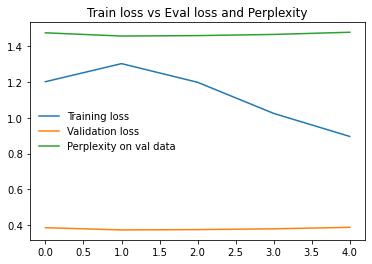

In [37]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [38]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [42]:
#Xtest = X_valid.iloc[11600:12600]
indices = np.random.permutation(len(X_valid))
ind = indices[:1000]
Xtest = X_valid.iloc[ind]

xtest = Xtest.reset_index(drop=True)
val_arg = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
val_loader  = get_dataloader(xtest, 5,valid='valid', **val_arg)

In [43]:
%time results = generator(model, val_loader)

CPU times: user 32min 37s, sys: 1min 1s, total: 33min 39s
Wall time: 19min 28s


#### Visualizing examples

**Example 1**

In [48]:
examples = 10

for ex in range(len(results['golden_summary'])):
    print(f'Example:{ex}\n')
    print(xtest.iloc[ex,:]['text'])
    print("\nActual summary:\n")
    print(results['golden_summary'][ex])
    print('\nGenerated summary:\n')
    print(results['generated_summary'][ex])
    print('-'*10)
    
    if ex == examples:
        break
    

Example:0

Ultra Orthodox Jews attend the funeral of Rabbi Yosef Shalom Elyashiv in Jerusalem, Wednesday, July 18, 2012. Elyashiv, revered by Jews worldwide as the top rabbinic authority of this generation for his scholarship and rulings on complex elements of Jewish law, died Wednesday, hospital officials said. He was 102.

Oded Balilty AP for TIME

Elhanan Gibli found God. not just in the personal salvation sense. There was an address.

God was last known to reside approximately 300 yards north of the minimart at the corner of Ma ale HaShalom and Wadi Hilwa. There stood the Second Temple, built around the Ark of the Covenant containing the Holy of Holies. And two millennia after the temple s destruction, the power of the divine still radiated so potently from the remaining stones that Gibli recalls feeling it in his entire being the first time he entered Jerusalem s Old City, at age 13. The welling of awe affirmed a pair of.

Current print subscribers to register

Subscribe now to ge

In [49]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'With their numbers and their political clout growing, the ultra Orthodox aren t just changing the makeup of Jerusalem. They are altering Israel s national identity'

In [50]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'Elyashiv, revered by Jews worldwide as the top rabbinic authority of this generation for his scholarship and rulings on complex elements of Jewish law, died Wednesday, hospital officials said. He was 102. Oded Balilty AP for TIME Elhanan Gibli found God. not just in the personal salvation sense. There was an address'

**Example 2**

In [52]:
xtest.iloc[1,:]['text']

'One of the hottest topics among business people is how to increase profits by being environmentally friendly. There are many ways to achieve this. At hotels, for instance, by not washing towels during a guest s stay unless the guest asks, the hotel saves both money and the environment. Green innovations can be featured in advertising campaigns to attract customers. Another potential benefit of going green is that it makes environmentally minded employees happy, increasing their loyalty to the firm.\n\nA Berlin brothel has hit on another way to use environmental arguments to its benefit price discrimination. Mary MacPherson Lane writes in an AP article \n\nThe bordellos in the capital of Germany, where prostitution is legal, have seen business suffer with the global financial crisis. Patrons have become more frugal and there are fewer potential customers coming to the city for business trips and conferences.\n\nBut Maison d Envie has seen its business begin to return since it began off

In [53]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'One of the hottest topics among business people is how to increase profits by being environmentally friendly. There are many ways to achieve this. At hotels, for instance, by not washing towels during a guest s stay unless the guest asks, the hotel saves both money and the environment. Green innovations can be featured in advertising campaigns to attract customers. Another potential benefit of going green is that it makes environmentally minded employees happy, increasing their loyalty to the firm. A Berlin brothel has hit on another way to use environmental arguments to its benefit.'

In [54]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'One of the hottest topics among business people is how to increase profits by being environmentally friendly. There are many ways to achieve this. At hotels, for instance, by not washing towels during a guest s stay unless the guest asks, the hotel saves both money and the environment. Green innovations can be featured in advertising campaigns to attract customers. Another potential benefit of going green is that it makes environmentally minded employees happy, increasing their loyalty'

**Example 3**

In [55]:
xtest.iloc[2,:]['text']

'RIVERSIDE, Calif. As federal officials scour the backgrounds of the couple who went on a terrorist rampage here last week, they are looking carefully at Enrique Marquez, a childhood friend and relation by marriage of the husband, Syed Rizwan Farook. It was Mr. Marquez, 24, who bought the two assault rifles that Mr. Farook and his wife, Tashfeen Malik, used to carry out the attack, which killed 14 people and wounded 21 others.\n\nMr. Marquez, who works at a Walmart store, bought the weapons legally in 2011 or 2012 and either gave or sold them to Mr. Farook, federal officials said. Investigators have spoken with Mr. Marquez and were keeping close tabs on him although they have not named him as a suspect, they believe he has knowledge about the Farook family and its recent activities.\n\nIn November 2014, Mr. Marquez married Mariya Chernykh, whose sister, Tatiana, is married to Syed Raheel Farook, brother of Syed Rizwan Farook. Tatiana Farook is a hairstylist and makeup artist who also g

In [56]:
print("Actual summary:")
results['golden_summary'][2]

Actual summary:


'Mr. Marquez, who bought the assault rifles used in the rampage, was a neighbor of one of the attackers. Officials hope he holds clues about their thinking.'

In [57]:
print('Generated summary:')
results['generated_summary'][2]

Generated summary:


'Enrique Marquez bought the two assault rifles that Syed Rizwan Farook and his wife, Tashfeen Malik, used to carry out the attack.'

**Example 4**

In [58]:
xtest.iloc[3,:]['text']

'By Sue Kirchhoff, USA TODAY\n\nWASHINGTON Consumer confidence plunged to the lowest since the onset of the Iraq war in 2003, while wholesale inflation surged to the highest yearly rate in a quarter century, according to Tuesday reports offering fresh evidence the economy is teetering near recession.\n\nAlso Tuesday, a closely watched index indicated U.S. home prices dropped 9 in the final quarter of 2007 from a year earlier. That s the steepest decline in the 20 year history of the SandP Case Shiller home price index.\n\nThe reports complicate the work of the Federal Reserve, which has been cutting interest rates since September to ease a credit crunch in financial markets and bolster business and consumer spending.\n\nThe central bank s ability to maneuver could be limited if the inflation rate continues rising. But in a Tuesday speech, Fed Vice Chairman Donald Kohn suggested the Fed is worried more about slow growth than rising prices. I do not expect the recent elevated inflation r

In [59]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'Consumer confidence plunged to its lowest level since the start of the Iraq war, while wholesale inflation surged to its highest yearly rate in a quarter century in January, according to Tuesday reports offering fresh evidence the economy is veering.'

In [60]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'By Sue Kirchhoff, USA TODAY WASHINGTON Consumer confidence plunged to the lowest since the onset of the Iraq war in 2003, while wholesale inflation surgedto the highest yearly rate in a quarter century, according to Tuesday reports offering fresh evidence the economy is teetering near recession. Also Tuesday, a closely watched index indicated U.S. home prices dropped 9'

In [64]:
xtest.iloc[20,:]['text']

'First things first just in case the headline isn t enough of a giveaway, this article may contain spoilers for Zack Snyder s forthcoming Batman v Superman Dawn of Justice, which stars Ben Affleck and Henry Cavill as the warring superheroes. If you don t like spoilers, we suggest you click away now, and look at this picture of Harrison Ford instead.\n\nWe re saying may contain spoilers , because it s not yet 100 clear whether the source of the new details is accurate. A Reddit user named ViolatingNDA, who is claiming to have seen an early screening of the film, has posted some plot and character information online, alongside a general review of the film.\n\nWhen challenged by commenters, the user provided a screen shot of a Warner Bros screening invitation as proof that he she actually saw the movie not the most compelling evidence in the world . It s also worth noting that there s been no corroboration of the rumours from other Hollywood based sources, and no confirmation that a scree

In [69]:
print("Actual summary:")
results['golden_summary'][20]

Actual summary:


'A Reddit user claiming to have seen the film has revealed several major plot points'

In [74]:
print('Generated summary:')
results['generated_summary'][20]

Generated summary:


'First things first just in case the headline isn t enough of a giveaway, this article may contain spoilers for Zack Snyder s forthcoming Batman v Superman Dawn'

In [65]:
xtest.iloc[21,:]['text']

'The Coast Guard is searching for a man swept out to sea in Northern California while taking pictures of tsunami waves.\n\nNearby, authorities in Brookings, Ore., say four people have survived after a tsunami surge swept them off a beach in Curry County and into the sea.\n\nThe five were on the beach Friday to watch the waves generated by a massive earthquake in Japan. The Curry County sheriff s department says two were able to get out of the water on their own, and two were rescued by law enforcement and fire officials.\n\nA man was also found dead aboard a commercial vessel in Brookings, but sheriff s officials said it appeared to be from natural causes.\n\nThe large waves shook loose boats in that weren t moved in time and tore apart wooden docks in at least two California harbors.\n\n This is just devastating. I never thought I d see this again, said Ted Scott, a retired mill worker who lived in Crescent City when a 1964 tsunami killed 17 people on the West Coast, including 11 in h

In [70]:
print("Actual summary:")
results['golden_summary'][21]

Actual summary:


'The Coast Guard is searching for a man who was swept out to sea in Northern California while taking pictures of the tsunami waves Friday.'

In [75]:
print('Generated summary:')
results['generated_summary'][21]

Generated summary:


'The Coast Guard is searching for a man swept out to sea in Northern California while taking pictures of tsunami waves. Nearby, authorities in Brookings, Ore., say four people have survived after a tsunami surge swept them off a beach in Curry County and into the sea. The five were on the beach Friday'

In [66]:
xtest.iloc[22,:]['text']

'Art deco buildings in Miami Beach. Press Association \n\nCuban food, Latin American culture, babe filled beaches, and models, lots and lots of models Miami is a great melting pot of all types who find themselves on the suntanned shores of the Gold Coast in search of a good time.\n\nIt is the antidote to Mickey Mouse and the gated communities and pink stucco that south Florida replicates in robotic fashion. The city suffered from the recession and foreclosure cyclone that shook Florida, but that means it is a better bargain than it has been in years. It is also definitely a year round destination, so the longer you spend there, the better.\n\nWhat is it known for? The rhythm is gonna get you here. Just a wander up Lincoln Road on South Beach and a quick cortadito espresso from David s Caf on Collins Avenue is all you need to get in the mood. Miami is a party town for all sorts of visitors, and not that just the kind that arrive in a speed boat, Miami Vice style. South Beach is usually 

In [71]:
print("Actual summary:")
results['golden_summary'][22]

Actual summary:


'The Cuban food, Latin American culture, beaches and models attract those in search of a good time.'

In [76]:
print('Generated summary:')
results['generated_summary'][22]

Generated summary:


'The city suffered from the recession and foreclosure cyclone that shook Florida, but that means it is a better bargain than it has been in years.'

In [67]:
xtest.iloc[23,:]['text']

'Edward Daly, who as the Roman Catholic bishop of Northern Ireland s second largest city argued relentlessly for peace during the three decades of sectarian violence known as the Troubles, died on Monday in Londonderry. He was 82.\n\nHis death, at Altnagelvin Area Hospital, was announced by Bishop Donal McKeown of Derry, the diocese that Bishop Daly led from 1974 to 1993, when he stepped down after having a stroke. The city, officially Londonderry, is commonly known by its shorter name. He was hospitalized after a fall several weeks ago.\n\n Bishop Daly served, without any concern for himself, throughout the traumatic years of the Troubles, finding his ministry shaped by the experience of witnessing violence and its effects, Bishop McKeown said in a statement.\n\nOn Jan. 30, 1972, as a 38 year old curate at St. Eugene s Cathedral, Father Daly escorted unarmed protesters on a march toward the city center when British soldiers opened fire, resulting in the deaths of 14 people. The massac

In [72]:
print("Actual summary:")
results['golden_summary'][23]

Actual summary:


'As a priest and later as bishop, he argued relentlessly for peace during the three decades of sectarian violence.'

In [77]:
print('Generated summary:')
results['generated_summary'][23]

Generated summary:


'The Roman Catholic bishop of Northern Ireland s second largest city argued relentlessly for peace during the three decades of sectarian violence known as the Troubles.'

In [68]:
xtest.iloc[30,:]['text']

'Lindsay Lohan s biggest sobriety aid a kind of tea called Kombucha that usually contains harmless traces of alcohol could get LiLo in serious SCRAM trouble . because it might be more alcoholic than she thought.According to the label, the tea contains less than 0.5 alcohol a negligible amount but Whole Foods recently yanked all the teas from their shelves over concerns the label isn t so accurate.The guy behind Kombucha, GT Dave, admitted there are concerns over alcohol levels in the drink but tells TMZ, Although we are not familiar with the technology or sensitivity of SCRAM bracelets, we think it would be highly unlikely that our products would trigger an alarm. Bottom line, Lindsay would probably have to drink a ton of this stuff to set off her SCRAM shackle but that s not to say she couldn t do it.\n\nTags Lindsay Lohan, Developing Stories, Celebrity Justice'

In [73]:
print("Actual summary:")
results['golden_summary'][30]

Actual summary:


'Lindsay Lohan s biggest sobriety aid a kind of tea called Kombucha that usually contains harmless traces of alcohol could get LiLo in serious'

In [78]:
print('Generated summary:')
results['generated_summary'][30]

Generated summary:


'Lindsay Lohan s biggest sobriety aid a kind of tea called Kombucha that usually contains harmless traces of alcohol could get LiLo in serious SCRAM trouble. because it might be more alcoholic than'

### Performance

In [62]:
!pip3 install rouge
from rouge import Rouge

In [63]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

     |████████████████████████████████| 104 kB 6.5 MB/s eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=869b584340fee616c3bc9bf5f854b09a96c5e4bf01914e637d615b22fd92487c
  Stored in directory: /home/jupyter/.cache/pip/wheels/cc/af/1a/498a24d0730ef484019e007bb9e8cef3ac00311a672c049a3e
Successfully built absl-py


In [79]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [80]:
get_score(results)

{'rouge1': 0.39125958591653576,
 'rouge2': 0.2660470961210495,
 'rougeL': 0.3460145925856343}

In [81]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.365011292445863,
 'rouge-2': 0.2552586262863975,
 'rouge-l': 0.35304477720327215}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])